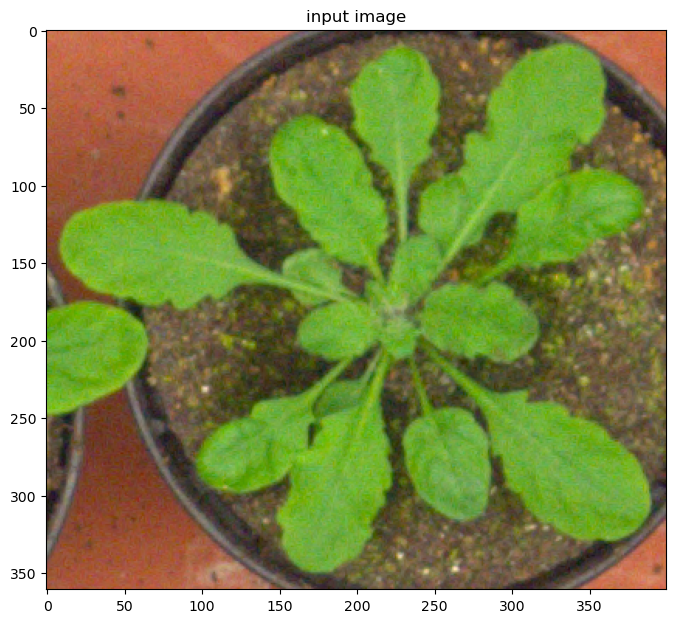

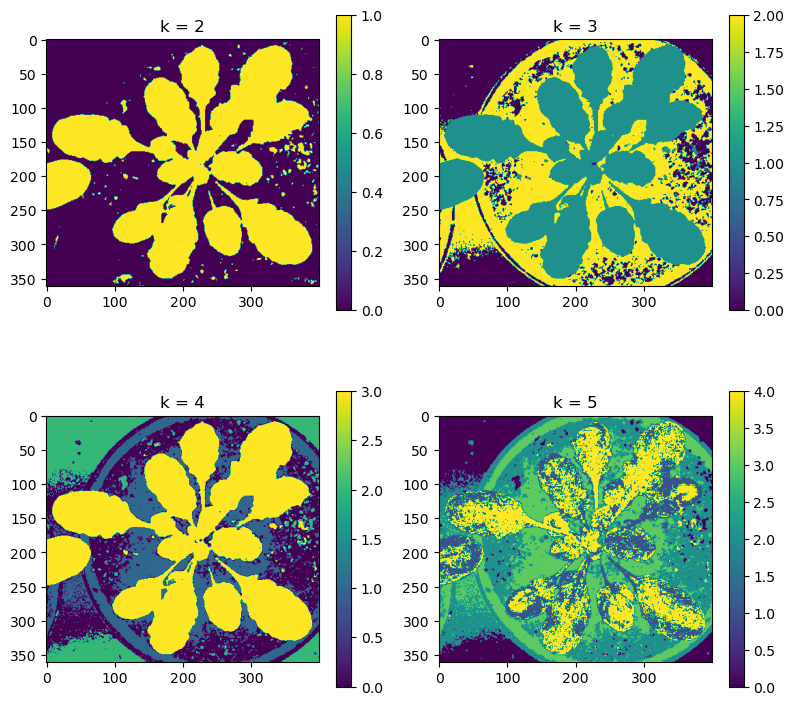

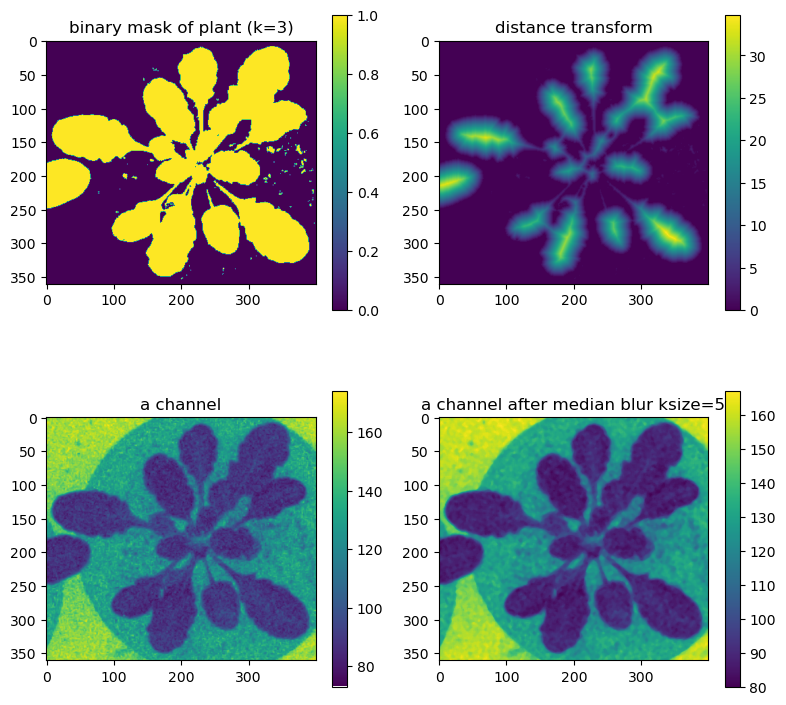

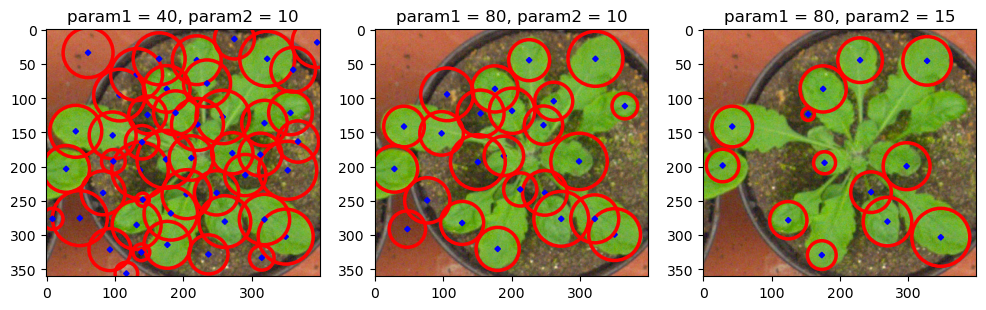

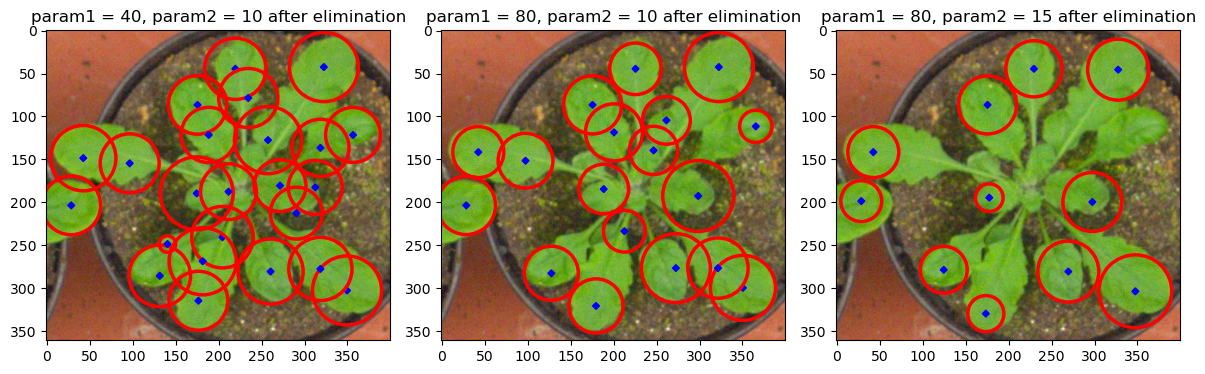

In [17]:
#Şevval Kaplan & Şevval Yardımcı Group Homework-3

import cv2
import numpy as np
import matplotlib.pyplot as plt

#loading RGB image and displaying the original input
image = cv2.imread('ara2012_plant115_rgb.png')
plt.figure(figsize=(8, 8))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('input image')
plt.show()

#reshaping the image to 2D
pixels = image.reshape(-1, 3)

#performed k-means clustering for different k values
k_values = [2, 3, 4, 5]
segmentations = []

for k in k_values:
    _, labels, centers = cv2.kmeans(pixels.astype(np.float32), k, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape(image.shape[:2])
    segmentations.append(segmented_image)

#displaying the results in a for loop
plt.figure(figsize=(8, 8))

for i, segmentation in enumerate(segmentations):
    plt.subplot(2, 2, i+1)
    plt.imshow(segmentation, cmap='viridis')
    plt.colorbar(shrink=0.75)
    plt.title(f'k = {k_values[i]}')


plt.tight_layout()
plt.show()

#choosing k-value for masking
chosen_segmentation = segmentations[1]  

#masking
binary_mask = np.where(chosen_segmentation == 1, 1, 0)

#distance transform
dist_transform = cv2.distanceTransform(binary_mask.astype(np.uint8), cv2.DIST_L2, 3)

#displaying the binary mask and distance transform results
plt.figure(figsize=(8, 8))

plt.subplot(2, 2,1)
plt.imshow(binary_mask, cmap='viridis')
plt.title('binary mask of plant (k=3)')
plt.colorbar(shrink=0.75)

plt.subplot(2, 2,2)
plt.imshow(dist_transform, cmap='viridis')
plt.title('distance transform')
plt.colorbar(shrink=0.75)


#calculating the minRadius and maxRadius
max_distance = np.max(dist_transform)
min_radius = int(max_distance * 0.25)
max_radius = int(max_distance * 1.25)

#RGB image to LAB
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

#select the a* channel
a_channel = lab_image[:, :, 1]

#blur the a* channel
filtered_a = cv2.medianBlur(a_channel, 5)

plt.subplot(2, 2,3)
plt.imshow(a_channel, cmap='viridis')
plt.title('a channel')
plt.colorbar(shrink=0.75)

plt.subplot(2, 2,4)
plt.imshow(filtered_a, cmap='viridis')
plt.title('a channel after median blur ksize=5')
plt.colorbar(shrink=0.75)
plt.tight_layout()
plt.show()


#detecting the circles by Hough Transform for different parameters
param1_values = [40, 80, 80]
param2_values = [10, 10, 15]
detection_results = []

for param1, param2 in zip(param1_values, param2_values):
    circles = cv2.HoughCircles(filtered_a, cv2.HOUGH_GRADIENT, dp=1, minDist=0.1 * min(image.shape[:2]), param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    if circles is not None:
        detection_results.append(circles[0])
    else:
        detection_results.append([])

plt.figure(figsize=(12, 4))

for i, circles in enumerate(detection_results):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(f'param1 = {param1_values[i]}, param2 = {param2_values[i]}')

    if len(circles) > 0:
        for circle in circles:
            x, y, radius = circle
            circle_patch = plt.Circle((x, y), radius, color='r', fill=False,linewidth=2.5)
            plt.gca().add_patch(circle_patch)
            
            # Add a diamond at the center of the circle
            diamond_patch = plt.Polygon([[x-4, y], [x, y-4], [x+4, y], [x, y+4]], color='b', closed=True)
            plt.gca().add_patch(diamond_patch)
    

plt.show()


def eliminate_invalid_detections(circles, binary_mask):
    valid_circles = []
    for circle in circles:
        x, y, _ = circle 
        
        if binary_mask[int(y), int(x)] != 0:
            valid_circles.append(circle)

    return valid_circles


plt.figure(figsize=(12, 4))

for i, (param1, param2) in enumerate(zip(param1_values, param2_values)):
    chosen_detection = detection_results[i]

    #eliminating invalid detections using the binary mask
    valid_circles = eliminate_invalid_detections(chosen_detection, binary_mask)

    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

    plt.title(f'param1 = {param1}, param2 = {param2} after elimination')

    for circle in valid_circles:
        x, y, radius = circle
        circle_patch = plt.Circle((x, y), radius, color='r', fill=False,linewidth=2.5)
        plt.gca().add_patch(circle_patch)
        
        diamond_patch = plt.Polygon([[x-4, y], [x, y-4], [x+4, y], [x, y+4]], color='b', closed=True)
        plt.gca().add_patch(diamond_patch)


plt.tight_layout()

plt.show()
